In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import sys
sys.path.append("/home/mylab-pharma/Code/tuele/pan_HDAC/mylab_panHDAC-master/src/common")
from pharmacy_common import PharmacyCommon

#class to encode smiles
common = PharmacyCommon()

In [2]:
train_dataset = pd.read_excel('../../data/train_test_data/NoCL/20240321_pan_HDAC_train_test_data.xlsx',sheet_name='train_dataset')
validation_dataset = pd.read_excel("../../data/train_test_data/NoCL/20240321_pan_HDAC_train_test_data.xlsx", sheet_name='validation_dataset')
test_dataset = pd.read_excel("../../data/train_test_data/NoCL/20240321_pan_HDAC_train_test_data.xlsx", sheet_name='test_dataset')
print(len(train_dataset),len(validation_dataset), len(test_dataset))

1528 328 327


In [3]:
train_dataset.head(10)

,Code,SMILES,Bioactivity
0,415897,CC(Nc1ccc(CN(CCC=C2CCC(NO)=O)C2=O)cc1)=O,inactive
1,1589183,COc(cc(/C=C/C(Nc(cccc1)c1N)=O)cc1)c1OCC(Nc(cc1...,inactive
2,1161066,CC[C@H](C)[C@@H](C(N(Cc1c(C2)ccc(OCC(NO)=O)c1)...,active
3,2100074,CC(c1ccccc1)Nc1ncnc2c1cc(-c1ccc(CN3CCN(CCOCCCC...,inactive
4,386804,CC(C)SC(SCC(c1ccc(C)cc1)=O)=S,inactive
5,467667,CCOC(SCC(c(cc1)ccc1NC(C)=O)=O)=S,inactive
6,390739,ONC(/C=C/c1cccc(C(c2cc(cccc3)c3[nH]2)=O)c1)=O,active
7,440474,ONC(CCCCCNC(Nc1cc(-c2nc(cccc3)c3[o]2)ccc1)=O)=O,active
8,2460036,CN1C(SCc(cc2)ccc2C(Nc(cccc2)c2N)=O)=Nc(cc(cc2)...,inactive
9,440227,CCC(c1nc(cccc2)c2[n]1CC)c1ccc(/C=C/C(NO)=O)cc1,active


In [4]:
#encoding smiles 
fpt_bits = 1024
X_train = common.gen_ecfp4_fpts(train_dataset['SMILES'],bits = 1024)
X_validation = common.gen_ecfp4_fpts(validation_dataset['SMILES'], bits = 1024)
X_test = common.gen_ecfp4_fpts(test_dataset['SMILES'], bits = 1024)

Progress:   0%|          | 0/1528 [00:00<?, ?it/s][18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05:04] DEPRECATION WARNING: please use MorganGenerator
[18:05

In [5]:
# encoding the label
import sklearn.preprocessing as preprocessing
y_train = np.array(train_dataset['Bioactivity'])
y_validation = np.array(validation_dataset['Bioactivity'])
y_test = np.array(test_dataset['Bioactivity'])

#Original data
print("Original data:")
print(y_train[0:5])
print(y_test[0:5])
print(y_validation[0:5])

#label encoding
label_encoder = preprocessing.LabelEncoder()
y_train  = label_encoder.fit_transform(y_train)
y_validation = label_encoder.fit_transform(y_validation)
y_test = label_encoder.fit_transform(y_test)
#Class encoded
print("Class encoded:")
print(list(label_encoder.classes_))
print(label_encoder.transform(label_encoder.classes_))
print("Encoded data:")
print(y_train[0:5])
print(y_test[0:5])
print(y_validation[0:5])

Original data:
['inactive' 'inactive' 'active' 'inactive' 'inactive']
['active' 'active' 'active' 'inactive' 'active']
['active' 'active' 'inactive' 'inactive' 'inactive']
Class encoded:
['active', 'inactive']
[0 1]
Encoded data:
[1 1 0 1 1]
[0 0 0 1 0]
[0 0 1 1 1]


In [6]:
#converting to tensor 
X_train_df = pd.DataFrame(X_train)
X_validation_df = pd.DataFrame(X_validation)
X_test_df = pd.DataFrame(X_test)

X_train = torch.tensor(X_train_df.values, dtype=torch.float32)
X_validation = torch.tensor(X_validation_df.values, dtype=torch.float32)
X_test = torch.tensor(X_test_df.values, dtype=torch.float32)

y_train_df = pd.DataFrame(y_train)
y_validation_df = pd.DataFrame(y_validation)
y_test_df = pd.DataFrame(y_test)

y_train = torch.tensor(y_train_df.values, dtype=torch.float32)
y_validation = torch.tensor(y_validation_df.values, dtype=torch.float32)
y_test = torch.tensor(y_test_df.values, dtype=torch.float32)

# Create train and test datasets
train_dataset = TensorDataset(X_train, y_train)
validation_dataset= TensorDataset(X_validation, y_validation)
test_dataset = TensorDataset(X_test, y_test)

In [7]:
# Define the data loaders
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
data_train = X_train
data_valdation = X_validation
data_test = X_test

labels_validation = y_validation
labels_test = y_test
labels_train= y_train.float()
print(len(data_train), len(labels_train),len(data_valdation),
    len(labels_validation), len(data_test), len(labels_test))
print(data_train)
print(labels_train)

1528 1528 328 328 327 327
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[1.],
        [1.],
        [0.],
        ...,
        [0.],
        [1.],
        [1.]])


In [9]:
# create a class for the model

class ann_try(nn.Module):
  def __init__(self,nUnits,nLayers):
    super().__init__()

    # create dictionary to store the layers
    self.layers = nn.ModuleDict()
    self.nLayers = nLayers

    ### input layer
    self.layers['input'] = nn.Linear(1024,nUnits)

    ### hidden layers
    for i in range(nLayers):
      self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)

    ### output layer
    self.layers['output'] = nn.Linear(nUnits,1)


  # forward pass
  def forward(self,x):
    # input layer (note: the code in the video omits the relu after this layer)
    x = F.relu( self.layers['input'](x) )

    # hidden layers
    for i in range(self.nLayers):
      x = F.relu( self.layers[f'hidden{i}'](x) )

    # return output layer
    x = F.sigmoid(self.layers['output'](x))
    return x

In [10]:
# generate an instance of the model and inspect it
nUnitsPerLayer = 10
nLayers = 2
net = ann_try(nUnitsPerLayer,nLayers)
net

ann_try(
  (layers): ModuleDict(
    (input): Linear(in_features=1024, out_features=10, bias=True)
    (hidden0): Linear(in_features=10, out_features=10, bias=True)
    (hidden1): Linear(in_features=10, out_features=10, bias=True)
    (output): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [11]:
# A quick test of running some numbers through the model.
# This simply ensures that the architecture is internally consistent.
# 10 samples, 167 dimensions
tmpx = torch.randn(10,1024)

# run it through the DL
y = net(tmpx)

# exam the shape of the output
print( y.shape ), print(' ')

# and the output itself
print(y)

torch.Size([10, 1])
 
tensor([[0.4677],
        [0.4726],
        [0.4764],
        [0.4597],
        [0.4611],
        [0.4796],
        [0.4611],
        [0.4734],
        [0.4774],
        [0.4706]], grad_fn=<SigmoidBackward0>)


Create a function that trains the model

In [12]:
# a function to train the model

def trainTheModel(ann_try):
  lr = 0.001
  l2 = 0.001
  lossfun = nn.BCELoss()
  optimizer = torch.optim.Adam(ann_try.parameters(),lr= lr,weight_decay= l2)

  # loop over epochs
  for epochi in range(numepochs):

    # forward pass
    yHat = ann_try(data_train)

    # compute loss
    loss = lossfun(yHat,labels_train)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # final forward pass to get loss final

  y_pred_train = ann_try(data_train)>.5
  acc_train = 100*torch.mean((y_pred_train == y_train).float())
  y_pred_val = ann_try(data_valdation)>.5
  acc_val = 100*torch.mean((y_pred_val == y_validation).float())
  loss_final = mean_squared_error(y_pred_train, y_train)

  # total number of trainable parameters in the model
  nParams = sum(p.numel() for p in ann_try.parameters() if p.requires_grad)

  # function outputs
  return loss_final, nParams, acc_val

In [13]:
# test the function once

numepochs = 500
loss_final = trainTheModel(net)

# check the outputs
loss_final # tuple containing (accuracy,nparams)

(0.011125655, 10481, tensor(82.0122))

Now for the experiment!

In [14]:
# define the model parameters
numlayers = range(1,6)         # number of hidden layers
numunits  = np.arange(50,500,50) # 50 units per hidden layer

# initialize output matrices
loss_finals  = np.zeros((len(numunits),len(numlayers)))
totalparams = np.zeros((len(numunits),len(numlayers)))
acc_vals  = np.zeros((len(numunits),len(numlayers)))
# number of training epochs
numepochs = 100


# start the experiment!
for unitidx in range(len(numunits)):
  for layeridx in range(len(numlayers)):

    # create a fresh model instance
    net = ann_try(numunits[unitidx],numlayers[layeridx])

    # run the model and store the results
    loss_final,nParams, acc_val = trainTheModel(net)
    loss_finals[unitidx,layeridx] = loss_final
    acc_vals[unitidx,layeridx] = acc_val



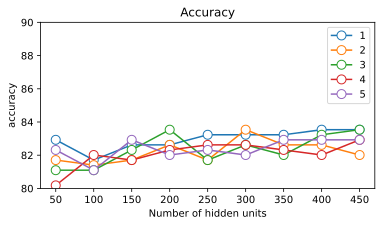

In [15]:
fig, ax = plt.subplots(1, figsize=(6, 3))

ax.plot(numunits, acc_vals, 'o-', markerfacecolor='w', markersize=9)
ax.plot(numunits[[0, -1]], [33, 33], '--', color=[.8, .8, .8])
ax.plot(numunits[[0, -1]], [67, 67], '--', color=[.8, .8, .8])
ax.legend(numlayers)
ax.set_ylabel('accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
ax.set_ylim(80, 90)  # Set the y-axis limits to 80-90
plt.show()

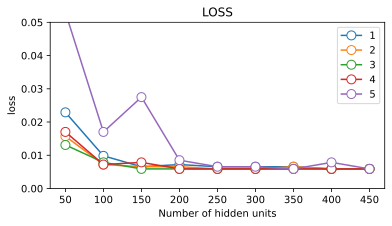

In [19]:
# show loss as a function of model depth
fig,ax = plt.subplots(1,figsize=(6,3))

ax.plot(numunits,loss_finals,'o-',markerfacecolor='w',markersize=9)
ax.plot(numunits[[0,-1]],[33,33],'--',color=[.8,.8,.8])
ax.plot(numunits[[0,-1]],[67,67],'--',color=[.8,.8,.8])
ax.legend(numlayers)
ax.set_ylabel('loss')
ax.set_xlabel('Number of hidden units')
ax.set_title('LOSS')
ax.set_ylim(0, 0.05)  # Set the y-axis limits to 80-90
plt.show()